# PyJAGS library test for bayesian statistics

#### The goal of this notebook is to test the pyjags library (bayesian statistics) Vs. scipy.stats (inferential statistics)

## 0. Import

PyJAGS (https://github.com/michaelnowotny/pyjags) works on MacOS and Linux. Windows is not currently supported.   
If you are on Windows, you will need a solution as WSL : https://ubuntu.com/wsl   

Once you download Ubuntu WSL, open a terminal and launch the following lines to get the appropriate environment with PyJAGS:  

sudo apt update   
sudo apt upgrade   
mkdir workspace   
mkdir pyjags-cookie-cats-ab-test   
sudo apt-get install python3-pip   
python3 -m pip install --upgrade pip   
sudo apt-get install python3-venv   
python3 -m venv env   
source env/bin/activate   
pip install jupyter   
python3 -m ipykernel install --user --name=pyjages-cookie-cats-ab-test   
sudo apt-get install pkg-config   
sudo apt-get install jags   
pip install numpy   
pip install pyjags   
pip install seaborn   

In [3]:
import os
from IPython.display import Image
import numpy as np
import pandas as pd
import pyjags
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

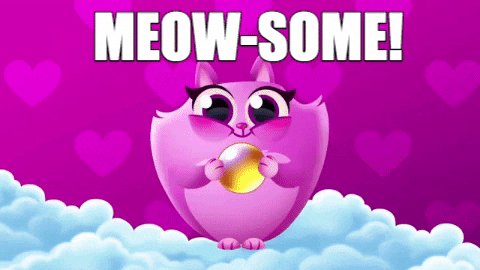

In [4]:
Image('https://media.giphy.com/media/39uiRxiFKDA2HaERFW/giphy.gif')

## 1. Dataset analysis

In [6]:
path = os.getcwd()

df = pd.read_csv(path + '/cookie_cats.csv')
df['retention_1'] = df['retention_1'].astype(int)
df['retention_7'] = df['retention_7'].astype(int)
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,0,0
1,337,gate_30,38,1,0
2,377,gate_40,165,1,0
3,483,gate_40,1,0,0
4,488,gate_40,179,1,1


In [7]:
df[['sum_gamerounds', 'retention_1', 'retention_7']].describe()

,sum_gamerounds,retention_1,retention_7
count,90189.000000,90189.000000,90189.000000
mean,51.872457,0.445210,0.186065
std,195.050858,0.496992,0.389161
min,0.000000,0.000000,0.000000
25%,5.000000,0.000000,0.000000
50%,16.000000,0.000000,0.000000
75%,51.000000,1.000000,0.000000
max,49854.000000,1.000000,1.000000


In [8]:
df.groupby('version').mean()[['sum_gamerounds', 'retention_1', 'retention_7']]

,sum_gamerounds,retention_1,retention_7
version,,,
gate_30,52.456264,0.448188,0.190201
gate_40,51.298776,0.442283,0.182000


It seems that gate_30 is better than gate_40 by 1% for the retention at 7 days.   
We need to verify that with statistical analysis.

## 2. Statistical analysis

### 2.1. One-day retention

#### 2.1.1. Bayesian approach

In [9]:
df['group'] = np.where(df['version'] == 'gate_30', 1, 2)
group = df['group'].tolist()

def summary(samples, varname, p=95):
    values = samples[varname]
    ci = np.percentile(values, [100-p, p])
    print(f"{varname} mean = {round(np.mean(values), 3)}, {p}% credible interval [{round(ci[0], 3)}; {round(ci[1], 3)}]")

We modelize a Bernoulli distribution and we aim to estimate the parameter of the law, which is theta (probability of success):

In [10]:
modelstring = """
                 model{
                 for (i in 1:N) {
                 y[i] ~ dbern(theta[group[i]])
                 }
                 for (j in 1:n) {
                 theta[j] ~ dbeta(1, 1)
                 }
                 theta_gate_30 = theta[1]
                 theta_gate_40 = theta[2]
                 }"""

In [11]:
y = df['retention_1']

np.random.seed(0)
N = len(y)
n = 2
model = pyjags.Model(modelstring, data=dict(group=group, y=y, N=N, n=n), chains=4)
samples = model.sample(5000, vars=['theta_gate_30', 'theta_gate_40'])
    
for varname in ['theta_gate_30', 'theta_gate_40']:
    summary(samples, varname)

sampling: iterations 1584 of 20000, elapsed 0:00:06, remaining 0:01:12
sampling: iterations 2852 of 20000, elapsed 0:00:11, remaining 0:01:08
sampling: iterations 4112 of 20000, elapsed 0:00:16, remaining 0:01:04
sampling: iterations 5360 of 20000, elapsed 0:00:21, remaining 0:00:59
sampling: iterations 7852 of 20000, elapsed 0:00:31, remaining 0:00:49
sampling: iterations 10348 of 20000, elapsed 0:00:41, remaining 0:00:39
sampling: iterations 11596 of 20000, elapsed 0:00:46, remaining 0:00:34
sampling: iterations 12840 of 20000, elapsed 0:00:52, remaining 0:00:29
sampling: iterations 14084 of 20000, elapsed 0:00:57, remaining 0:00:24
sampling: iterations 15324 of 20000, elapsed 0:01:02, remaining 0:00:19
sampling: iterations 17804 of 20000, elapsed 0:01:11, remaining 0:00:09
sampling: iterations 20000 of 20000, elapsed 0:01:20, remaining 0:00:00
sampling: iterations 20000 of 20000, elapsed 0:01:20, remaining 0:00:00
theta_gate_30 mean = 0.448, 95% credible interval [0.444; 0.452]
thet

Intervals are overlapping so we cannot say that the probability parameters are different.

#### 2.1.2. Inferential approach

In [12]:
gate_30 = df[df['version'] == 'gate_30']['retention_1']
gate_40 = df[df['version'] == 'gate_40']['retention_1']
res = stats.ttest_ind(gate_30, gate_40)
print(f"p-value: {res[1]}")

p-value: 0.07441111525563184


p-value > 0.05 : We cannot reject H0 (the 2 parameters are equal)

### 2.2. 7-days retention

#### 2.2.1. Bayesian approach

In [13]:
y = df['retention_7']

np.random.seed(0)
N = len(y)
n = 2
model = pyjags.Model(modelstring, data=dict(group=group, y=y, N=N, n=n), chains=4)
samples = model.sample(5000, vars=['theta_gate_30', 'theta_gate_40'])
    
for varname in ['theta_gate_30', 'theta_gate_40']:
    summary(samples, varname)

sampling: iterations 1572 of 20000, elapsed 0:00:06, remaining 0:01:14
sampling: iterations 2820 of 20000, elapsed 0:00:11, remaining 0:01:09
sampling: iterations 4056 of 20000, elapsed 0:00:17, remaining 0:01:05
sampling: iterations 6528 of 20000, elapsed 0:00:26, remaining 0:00:53
sampling: iterations 7788 of 20000, elapsed 0:00:31, remaining 0:00:49
sampling: iterations 9044 of 20000, elapsed 0:00:36, remaining 0:00:44
sampling: iterations 11556 of 20000, elapsed 0:00:46, remaining 0:00:33
sampling: iterations 14100 of 20000, elapsed 0:00:55, remaining 0:00:23
sampling: iterations 16672 of 20000, elapsed 0:01:04, remaining 0:00:13
sampling: iterations 19280 of 20000, elapsed 0:01:13, remaining 0:00:03
sampling: iterations 20000 of 20000, elapsed 0:01:16, remaining 0:00:00
theta_gate_30 mean = 0.19, 95% credible interval [0.187; 0.193]
theta_gate_40 mean = 0.182, 95% credible interval [0.179; 0.185]


Intervals don't overlapp so we can say that theta_gate_30 is better than theta_gate_40 : the retention at gate level 30 i better than gate level 40 by 1%.

#### 2.2.2. Inferential approach

In [14]:
gate_30 = df[df['version'] == 'gate_30']['retention_7']
gate_40 = df[df['version'] == 'gate_40']['retention_7']
res = stats.ttest_ind(gate_30, gate_40)
print(f"p-value: {res[1]}")

p-value: 0.0015540151201088365


p-value < 0.05 : we can reject H0 that the 2 probabilities are equal.

### 2.3. Number of gamerounds

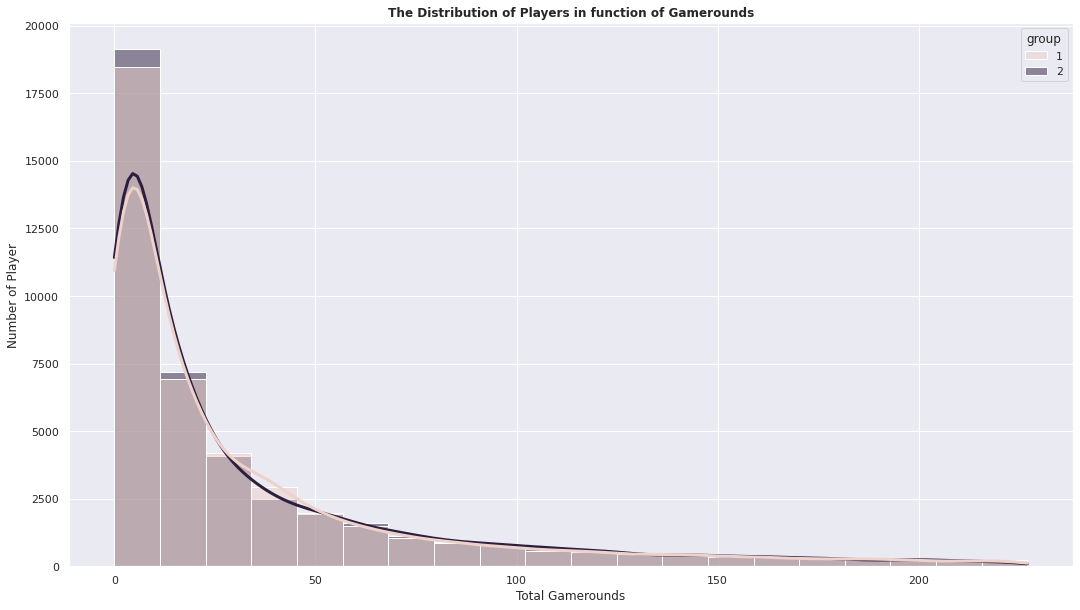

In [17]:
sns.set(rc={'figure.figsize':(18,10)})
sns.histplot(data=df[df.sum_gamerounds<228], x="sum_gamerounds", kde=True,hue="group",line_kws={"lw":3},bins=20)
plt.title("The Distribution of Players in function of Gamerounds", fontweight="bold")
plt.xlabel("Total Gamerounds")
plt.ylabel("Number of Player")
plt.show()

The number of gamerounds follows a Poisson distribution.

#### 2.3.1. Bayesian approach

In [18]:
modelstring = """
                 model{
                 for (i in 1:N) {
                 y[i] ~ dpois(lambda[group[i]])
                 }
                 for (j in 1:n) {
                 lambda[j] ~ dgamma(0.01, 0.01)
                 }
                 lambda_gate_30 = lambda[1]
                 lambda_gate_40 = lambda[2]
                 }
                 """

In [19]:
y = df.groupby('sum_gamerounds').count()['userid'].tolist()

np.random.seed(0)
N = len(y)
n = 2
model = pyjags.Model(modelstring, data=dict(group=group, y=y, N=N, n=n), chains=4)
samples = model.sample(5000, vars=['lambda_gate_30', 'lambda_gate_40'])
    
for varname in ['lambda_gate_30', 'lambda_gate_40']:
    summary(samples, varname)

sampling: iterations 20000 of 20000, elapsed 0:00:00, remaining 0:00:00
lambda_gate_30 mean = 95.527, 95% credible interval [94.778; 96.275]
lambda_gate_40 mean = 95.954, 95% credible interval [95.212; 96.697]


Intervals are overlapping. We cannot say that the parameters lambda (mean) are different.

In [20]:
df['log_sum_gamerounds'] = np.log(df['sum_gamerounds'] + 1)
print(f"Mean: {df['log_sum_gamerounds'].mean()}")
print(f"Median: {df['log_sum_gamerounds'].median()}")

Mean: 2.8797464833479514
Median: 2.833213344056216


#### 2.3.2. Inferential approach

We need to log-transform the distribution to approach a normal distribution.

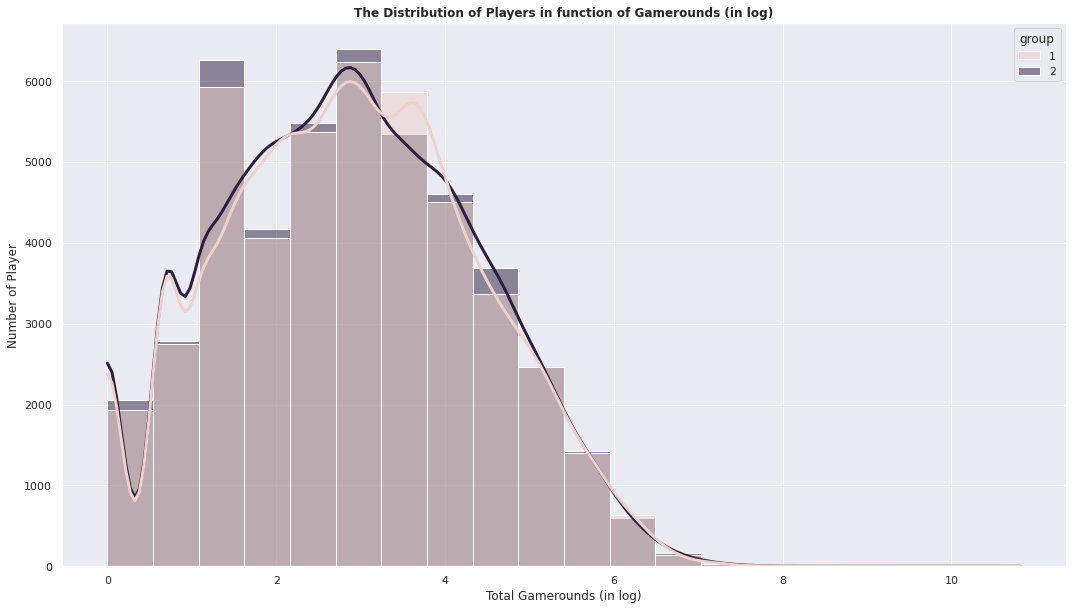

In [21]:
sns.set(rc={'figure.figsize':(18,10)})
sns.histplot(data=df, x="log_sum_gamerounds", kde=True,hue="group",line_kws={"lw":3},bins=20)
plt.title("The Distribution of Players in function of Gamerounds (in log)", fontweight="bold")
plt.xlabel("Total Gamerounds (in log)")
plt.ylabel("Number of Player")
plt.show()

In [22]:
gate_30 = df[df['version'] == 'gate_30']['log_sum_gamerounds']
gate_40 = df[df['version'] == 'gate_40']['log_sum_gamerounds']
res = stats.ttest_ind(gate_30, gate_40)
print(f"p-value: {res[1]}")

p-value: 0.06966089932684477


p-value > 0.05 : we cannot reject H0 that the 2 means are different.